In [1]:
import numpy as np
import itertools as itr

import os as os
import sys as sys 
import pandas as pd
import warnings
import time as time
import random
from __future__ import print_function # so print doesn't show brackets

sys.path.append(os.path.join("..","Libraries","QML_lib"))
import Evo as evo
import DataBase 
import QMD
import QML
import ModelGeneration
import BayesF
import matplotlib.pyplot as plt

global paulis_list
paulis_list = {'i' : np.eye(2), 'x' : evo.sigmax(), 'y' : evo.sigmay(), 'z' : evo.sigmaz()}

warnings.filterwarnings("ignore", message='Negative weights occured', category=RuntimeWarning)

class NewQMDClass():
    #TODO: rename as ModelsDevelopmentClass when finished
    def __init__(self,
                 initial_op_list,
                 true_operator='x',
                 true_param_list = None,
                 num_particles=1000,
                 max_num_models=10, 
                 max_num_qubits=4, 
                 gaussian=True,
                 max_num_layers = 10,
                 max_num_branches = 20, 
                 use_exp_custom = True,
                 debug_directory = None,
                 qle = True # Set to False for IQLE
                ):
#    def __init__(self, initial_op_list, true_op_list, true_param_list):
        self.QLE = qle # Set to False for IQLE
        trueOp = DataBase.operator(true_operator)
        self.TrueOpName = true_operator
        self.TrueOpDim = trueOp.num_qubits
        self.InitialOpList = initial_op_list
        self.TrueOpList = trueOp.constituents_operators
        if true_param_list is not None: 
            self.TrueParamsList = true_param_list
        else:
            print("No parameters passed, randomising")
            self.TrueParamsList = [random.random() for i in self.TrueOpList] # TODO: actual true params?
        # todo set true parmams properly
        #self.TrueParamsList = [0.75 for i in self.TrueOpList] # TODO: actual true params?
        #self.TrueHam = evo.getH(self.TrueParamsList, self.TrueOpList)
        self.TrueHam = np.tensordot(self.TrueParamsList, self.TrueOpList, axes=1)
        self.MaxModNum = max_num_models #TODO: necessary?
        self.gaussian = gaussian
        self.NumModels = len(initial_op_list)
        self.NumParticles = num_particles
        self.MaxQubitNumber = max_num_qubits
        self.NumProbes = 40
        self.ProbeDict = separable_probe_dict(max_num_qubits=self.MaxQubitNumber, num_probes=self.NumProbes)
        self.HighestQubitNumber = int(0)
        self.MaxBranchID = max_num_branches
        self.HighestBranchID = 0
        self.HighestModelID = len(initial_op_list)
        self.MaxLayerNumber = max_num_layers
        self.BranchChampions = {}
        self.LayerChampions = {}
        self.BayesFactorsByBranch ={}
        self.BranchRankings = {}
        self.BranchBayesComputed = {}
        self.InterBranchChampions = {}
        self.GlobalEpoch = 0 
        self.UseExpCustom = use_exp_custom
        self.DebugDirectory = debug_directory
        
        self.BranchBayesComputed[0] = False
#        for i in range(self.MaxBranchID+1):
#            self.BranchChampions[i] = 0
#        for i in range(self.MaxLayerNumber+1):
#            self.LayerChampions[i] = 0
        
        if self.QLE:
            print("Running QLE for true operator ", true_operator, " with parameters : ", self.TrueParamsList)
        else: 
            print("Running IQLE for true operator ", true_operator, " with parameters : ", self.TrueParamsList)
        # Initialise database and lists.
        self.initiateDB()
        
    def initiateDB(self):
        
        ## TODO: Models should be initialised with appropriate TrueOp dimension -- see getListTrueOpByDimension function
        self.db, self.legacy_db, self.model_lists = \
            DataBase.launch_db(
                true_op_name = self.TrueOpName,
                gen_list = self.InitialOpList,
                qle = self.QLE,
                true_ops = self.TrueOpList,
                true_params = self.TrueParamsList,
                num_particles = self.NumParticles,
                redimensionalise = False,
                num_probes = self.NumProbes,
                probe_dict = self.ProbeDict,
                use_exp_custom = self.UseExpCustom,
                debug_directory = self.DebugDirectory
            )
    def addModel(self, model, branchID=0):
        #self.NumModels += 1
        tryAddModel = DataBase.add_model(
            model_name = model,
            running_database = self.db,
            num_particles = self.NumParticles, 
            true_op_name = self.TrueOpName,
            model_lists = self.model_lists,
            true_ops = self.TrueOpList,
            true_params = self.TrueParamsList,
            branchID = branchID,
            num_probes = self.NumProbes,
            probe_dict = self.ProbeDict,
            use_exp_custom = self.UseExpCustom,
            debug_directory = self.DebugDirectory,
            modelID = self.NumModels,
            redimensionalise = False,
            qle = self.QLE
        )
        if tryAddModel == True: ## keep track of how many models/branches in play
            self.HighestModelID += 1 
            self.NumModels += 1
            if DataBase.get_num_qubits(model) > self.HighestQubitNumber:
                self.HighestQubitNumber = DataBase.get_num_qubits(model)
        #else: 
        #    self.NumModels-=int(1)

    def newBranch(self, model_list):
        self.HighestBranchID += 1
        branchID = self.HighestBranchID
        self.BranchBayesComputed[branchID] = False
        for model in model_list:
            self.addModel(model, branchID=branchID)
    
    def printState(self):
        print("Branch champions: \n", self.BranchChampions)
        print("InterBranch champions: \n", self.InterBranchChampions)
        print("Branch Rankings: \n", self.BranchRankings)
        #print("Layer Champions: \n", self.LayerChampions)
            
            
    def getModelInstance(self, name):
        try: 
            instance = DataBase.get_qml_instance(self.db, name)
            return instance
        except: 
            if name in list(self.legacy_db['<Name>']):
                print("Operator in legacy databse - retired. ")
            else: 
                print("Model not found.")
    def getOperatorInstance(self, name):
        try: 
            return DataBase.get_operator_instance(self.db, name)
        except:
            if name in list(self.legacy_db['<Name>']):
                print("Operator in legacy databse - retired. ")
            else: 
                print("Operator not found.")

    def getModelDBIndex(self, name):
        return DataBase.get_location(self.db, name)

    def getModelInstanceFromID(self, model_id):
        return DataBase.model_instance_from_id(self.db, model_id)    
    
    def killModel(self, name):
        if name not in list(self.db['<Name>']):
            print("Cannot remove ", name, "; not in ", list(self.db["<Name>"]))
        else:
            print("Killing model", name)
            # Add to legacy_db
            DataBase.move_to_legacy(self.db, self.legacy_db, name)
            model_instance = self.getModelInstance(name)
            operator_instance = self.getOperatorInstance(name)
            # Remove from self.db
            self.db = DataBase.remove_model(self.db, name)
            del model_instance
            del operator_instance
    
            #TODO: plot?

    def runIQLE(self, model, num_exp=50):
        model_exists=False
        if model in list(self.db['<Name>']):
            model_exists = True
        elif model in list(self.legacy_db['<Name>']):
            print("Model ", model, " previously considered and retired.")
        
        has_model_finished = self.pullField(name=model, field='Completed')
        
        if model_exists==True and has_model_finished==False : 
            model_instance = self.getModelInstance(model)
            print("\nRunning IQLE for model: ", model)
            model_instance.UpdateModel(num_exp)
            self.updateModelRecord(name=model, field='Completed', new_value=True)
            #model_instance.BayesOnModelsWithinbranches
        else: 
            print("Model ", model ,"does not exist")

    def runAllActiveModelsIQLE(self, num_exp):
        active_models = self.db.loc[self.db['Status']=='Active']['<Name>']

        for model in active_models:
            self.runIQLE(model=model, num_exp=num_exp)
        self.GlobalEpoch += num_exp
            
        
    def updateModelRecord(self, field, name=None, model_id=None, new_value=None, increment=None):
        DataBase.update_field(
            db=self.db, 
            name=name,
            model_id=model_id,
            field=field,
            new_value=new_value,
            increment=increment
        )
    def pullField(self, name, field):
        return DataBase.pull_field(self.db, name, field)

    def statusChangeBranch(self, branchID, new_status='Saturated'):
        self.db.loc[ self.db['branchID']==branchID , 'Status'] = new_status

    def statusChangeModel(self, model_name, new_status='Saturated'):
        self.db.loc[ self.db['<Name>']==model_name , 'Status'] = new_status
        
    def getListTrueOpByDimension(self):
        self.TrueOpListByDim = {}
        self.TrueParamByDim = {}
        for dim in range(1, 1+self.MaxDimension):
            new_op = ModelGeneration.identity_interact(subsystem=self.TrueOpName, num_qubits=dim, return_operator=True)
            self.TrueOpListByDim[dim] = new_op.constituents_operators
        for i in range(1, self.TrueOpDim+1):
            self.TrueParamByDim[i] = self.TrueParamsList
        for i in range(self.TrueOpDim+1, self.MaxDimension):
            self.TrueParamByDim[i] = [self.TrueParamsList[0]]

    def compareModels(self, log_comparison_high=50.0, num_times_to_use = 'all', model_a_id = None, model_b_id =None, model_a = None, model_b = None, name_a=None, name_b=None):
        # Either pass in name_a and name_b OR model_a and model_b
        if model_a is None and model_b is None:
            if model_a_id is not None and model_b_id is not None: 
                model_a = self.getModelInstanceFromID(model_a_id)
                model_b = self.getModelInstanceFromID(model_b_id)
            else: # if only names were passed 
                model_a = self.getModelInstance(name_a)
                model_b = self.getModelInstance(name_b)
        if model_a ==  model_b:
            return "Same Models"
        else: 
            log_comparison_low = 1.0/log_comparison_high
            if model_a_id is None and model_b is None:
                model_a_id = model_a.ModelID
                model_b_id = model_b.ModelID

            if num_times_to_use == 'all':
                times_a = model_a.TrackTime
            elif len(model_a.TrackTime) < num_times_to_use:
                times_a = model_a.TrackTime
            else: 
                times_a = model_a.TrackTime[num_times_to_use:]

            if num_times_to_use=='all':
                times_b = model_b.TrackTime
            elif len(model_b.TrackTime) < num_times_to_use:
                times_b = model_b.TrackTime
            else: 
                times_b = model_b.TrackTime[num_times_to_use:]
            gen_a = model_a.GenSimModel
            gen_b = model_b.GenSimModel

            times = times_a + times_b
            exps_a = get_exps(model_a, gen_a, times)
            exps_b = get_exps(model_b, gen_b, times)

            log_l_a =  get_log_likelihood(model_a, gen_a, exps_a)
            log_l_b =  get_log_likelihood(model_b, gen_b, exps_b)

            print("log likelihoods")
            print(name_a, " : ", log_l_a)
            print(name_b, " : ", log_l_b)
#            bayes_factor = np.expm1(log_l_a - log_l_b) +1 #todo: is this the right exp function?
            bayes_factor = np.exp(log_l_a - log_l_b)
            model_a.addBayesFactor(compared_with=model_b_id, bayes_factor=bayes_factor)
            model_b.addBayesFactor(compared_with=model_a_id, bayes_factor=1.0/bayes_factor)

            if bayes_factor >= log_comparison_high: 
             #   print("Point to ", model_a.Name)
                return "a"
            elif bayes_factor < log_comparison_low: 
             #   print("Point to ", model_b.Name)
                return "b"
            #else:
            #    print("No real winner")  
            # todo: Add bayes_factor with mod_id's to QML class

            
    def compareModelsWithinBranch(self, branchID):
        active_models_in_branch = DataBase.active_model_ids_by_branch_id(self.db, branchID)
        
        models_points = {}
        for model_id in active_models_in_branch:
            models_points[model_id] = 0
        
        for i in range(len(active_models_in_branch)):
            mod1 = active_models_in_branch[i]
            for j in range(i, len(active_models_in_branch)): 
                mod2 = active_models_in_branch[j]
                res = self.compareModels(model_a_id = mod1, model_b_id=mod2)
                if res == "a":
                    models_points[mod1] += 1
                elif res == "b":
                    models_points[mod2] += 1
                    # todo if more than one model has max points
                    
        max_points = max(models_points.values())
        max_points_branches = [key for key, val in models_points.items() if val==max_points]
        if len(max_points_branches) > 1: 
            # todo: recompare. Fnc: compareListOfModels (rather than branch based)
            champ_id = self.compareModelList(max_points_branches, bayes_threshold=1, models_points_dict=models_points)
        else: 
            champ_id = max(models_points, key=models_points.get)
        champ_name = DataBase.model_name_from_id(self.db, champ_id)
        
        #todo list of ranked models by branch
        
        self.BranchChampions[int(branchID)] = champ_id
        for model_id in active_models_in_branch:
            self.updateModelRecord(model_id=model_id, field='Status', new_value='Deactivated')
        self.updateModelRecord(name=DataBase.model_name_from_id(self.db, champ_id), field='Status', new_value='Active')

        ranked_model_list = sorted_keys = sorted(models_points, key=models_points.get, reverse=True)

        if self.BranchBayesComputed[int(float(branchID))] == False: # only update self.BranchRankings the first time branch is considered
            self.BranchRankings[int(float(branchID))] = ranked_model_list
            self.BranchBayesComputed[int(float(branchID))] = True
            
        print("Champion of branch ", branchID, " is ", champ_name)
        return models_points, champ_id

    
    def compareModelList(self, model_list, bayes_threshold = 50, models_points_dict=None):
        models_points = {}
        for mod in model_list:
            models_points[mod] = 0
        
        for i in range(len(model_list)):
            mod1 = model_list[i]
            for j in range(i, len(model_list)):
                mod2 = model_list[j]
                if mod1 != mod2:
                    res = self.compareModels(model_a_id=mod1, model_b_id=mod2, log_comparison_high=bayes_threshold)
                    if res == "a":
                        models_points[mod1] += 1
                        if models_points_dict is not None: 
                            models_points_dict[mod1]+=1
                    elif res == "b":
                        models_points[mod2]+=1
                        if models_points_dict is not None: 
                            models_points_dict[mod2]+=1

        max_points = max(models_points.values())
        max_points_branches = [key for key, val in models_points.items() if val==max_points]
        if len(max_points_branches) > 1: 
            # todo: recompare. Fnc: compareListOfModels (rather than branch based)
            print("No distinct champion, recomputing bayes factors between : ", max_points_branches)
            champ_id = self.compareModelList(max_points_branches, bayes_threshold=1)
        else: 
            champ_id = max(models_points, key=models_points.get)
        champ_name = DataBase.model_name_from_id(self.db, champ_id)

        
        return champ_id
    
    def interBranchChampion(self, branch_list=[], global_champion=False):
        all_branches = self.db['branchID'].unique()
        if global_champion == True: 
            branches = all_branches
        else: 
            branches = branch_list
        
        num_branches = len(branches)
        points_by_branches = [None] * num_branches
        champions_of_branches = [None] * num_branches

        for i in range(num_branches):
            branchID = branches[i]
            if branchID not in all_branches:
                print("branch ID : ", branchID)
                warnings.warn("branch not in database.")
                return False
            points_by_branches[i], champions_of_branches[i] = qmd.compareModelsWithinBranch(branchID)

        branch_champions_points = {}
        for c in champions_of_branches: 
            branch_champions_points[c] = 0

        for i in range(num_branches):
            mod1 = champions_of_branches[i]
            for j in range(i, num_branches):
                mod2 = champions_of_branches[j]
                if mod1!=mod2:
                    res = self.compareModels(model_a_id=mod1, model_b_id=mod2, log_comparison_high=20.0)
                    if res == "a":
                        branch_champions_points[mod1] += 1
                    elif res == "b":
                        branch_champions_points[mod2] += 1
        self.ranked_champions = sorted(branch_champions_points, reverse=True)
        
        max_points = max(branch_champions_points.values())
        max_points_branches = [key for key, val in branch_champions_points.items() if val==max_points]
        if len(max_points_branches) > 1: 
            # todo: recompare. Fnc: compareListOfModels (rather than branch based)
            print("No distinct champion, recomputing bayes factors between : ", max_points_branches)
            champ_id = self.compareModelList(max_points_branches, bayes_threshold=1, models_points_dict=branch_champions_points)
        else: 
            champ_id = max(branch_champions_points, key=branch_champions_points.get)
        champ_name = DataBase.model_name_from_id(self.db, champ_id)
        
        branch_champ_names = [DataBase.model_name_from_id(self.db, mod_id) for mod_id in champions_of_branches]
        self.statusChangeModel(champ_name, new_status = 'Active')
        
        interBranchChampListID = len(self.InterBranchChampions)
        self.InterBranchChampions[interBranchChampListID] = [branches, champ_id]
        return champ_name, branch_champ_names
    
    def globalChampionCalculation(self):
        branches = self.db['branchID'].unique()
        
        num_branches = len(branches)
        self.points_by_branches = [None] * num_branches
        self.champions_of_branches = [None] * num_branches

        for i in range(num_branches):
            branchID = branches[i]
            self.points_by_branches[i], self.champions_of_branches[i] = qmd.compareModelsWithinBranch(branchID)

        self.champions_points = {}
        for c in self.champions_of_branches: 
            self.champions_points[c] = 0

        for i in range(num_branches):
            mod1 = self.champions_of_branches[i]
            for j in range(i, num_branches):
                mod2 = self.champions_of_branches[j]
                if mod1!=mod2:
                    res = self.compareModels(model_a_id=mod1, model_b_id=mod2, log_comparison_high=10.0)
                    if res == "a":
                        self.champions_points[mod1] += 1
                    elif res == "b":
                        self.champions_points[mod2]+=1
        self.ranked_champions = sorted(self.champions_points, reverse=True)
        champ_id = max(self.champions_points, key=self.champions_points.get)
        champ_name = DataBase.model_name_from_id(self.db, champ_id)
        print("Champion of Champions is",  champ_name)
        
        
    def spawn(self, 
              branch_list = None, 
              num_models_to_consider=1, 
              absolute_champion=False, 
              all_branches=False
             ):

        if all_branches or branch_list is None: 
            global_champion = True
            
        overall_champ, branch_champions = self.interBranchChampion(branch_list=branch_list, global_champion=global_champion)

        if absolute_champion:
            new_models = ModelGeneration.new_model_list(model_list=[overall_champ], generator='simple_ising',options=['x', 'y'])
        else: 
            new_models = ModelGeneration.new_model_list(model_list=branch_champions, generator='simple_ising', options=['x', 'y'])
        
        print("New models to add to new branch : ", new_models)
        qmd.newBranch(model_list=new_models) 
        
        #todo probailistically append model_list with suboptimal model in any of the branches in branch_list

    def runQMD(self, num_exp = 20, max_branches= None, max_num_qubits = None, max_num_models=None):
        if max_branches is None:
            max_branches = self.MaxBranchID

        if max_num_qubits is None:
            max_num_qubits = self.MaxQubitNumber
            
        if max_num_models is None: 
            max_num_models = self.MaxModNum
            
        while self.HighestQubitNumber < max_num_qubits: 
            self.runAllActiveModelsIQLE(num_exp=num_exp)
            self.spawn()
            if self.HighestBranchID > max_branches or self.NumModels > max_num_models:
                break
            
        self.runAllActiveModelsIQLE(num_exp=num_exp)
        final_winner, final_branch_winners = self.interBranchChampion(global_champion=True)
        print("Final winner = ", final_winner)

    def inspectModel(self, name):
        print("\nmodel name: ", name)
        mod = self.getModelInstance(name)
        
        print("experiments done ", mod.NumExperimentsToDate)
        print("times: ",  mod.TrackTime)
        print("final params : ", mod.FinalParams)
        print("bayes factors: ", mod.BayesFactors)
        
def get_exps(model, gen, times):

    exps = np.empty(len(times), dtype=gen.expparams_dtype)
    exps['t'] = times

    for i in range(1, len(gen.expparams_dtype)):
        col_name = 'w_'+str(i)
        exps[col_name] = model.FinalParams[i-1,0] ## TODO: should be model.NewEval[i-1]???
    return exps

def get_log_likelihood(model, gen, exps):
    import copy
    updater = copy.deepcopy(model.Updater)
    data = gen.simulate_experiment(model.SimParams, exps)[0][0]
    updater.batch_update(data, exps, resample_interval=100)

    log_likelihood = updater.log_total_likelihood
    #if log_likelihood < 10e-16:
    #    print("log likelihood = ", log_likelihood, " so replacing with ", 1e-9)
    #    log_likelihood = 10e-16
    del updater
    #print("log likelihood = ", log_likelihood)
    return log_likelihood        


def separable_probe_dict(max_num_qubits, num_probes):
    seperable_probes = {}
    for i in range(num_probes):
        seperable_probes[i,0] = random_probe(1)
        for j in range(1, 1+max_num_qubits):
            if j==1:
                seperable_probes[i,j] = seperable_probes[i,0]
            else: 
                seperable_probes[i,j] = np.tensordot(seperable_probes[i,j-1], random_probe(1), axes=0).flatten(order='c')
            if np.linalg.norm(seperable_probes[i,j]) < 0.999999999 or np.linalg.norm(seperable_probes[i,j]) > 1.0000000000001:
                print("non-unit norm: ", np.linalg.norm(seperable_probes[i,j]))
    return seperable_probes

def random_probe(num_qubits):
    dim = 2**num_qubits
    real = np.random.rand(1,dim)
    imaginary = np.random.rand(1,dim)
    complex_vectors = np.empty([1, dim])
    complex_vectors = real +1.j*imaginary
    norm_factor = np.linalg.norm(complex_vectors)
    probe = complex_vectors/norm_factor
    return probe[0][:]

def get_directory_name_by_time(just_date=False):
    import datetime
    # Directory name based on date and time it was generated 
    # from https://www.saltycrane.com/blog/2008/06/how-to-get-current-date-and-time-in/
    now =  datetime.date.today()
    year = now.strftime("%y")
    month = now.strftime("%b")
    day = now.strftime("%d")
    hour = datetime.datetime.now().hour
    minute = datetime.datetime.now().minute
    date = str (str(day)+'_'+str(month)+'_'+str(year) )
    time = str(str(hour)+'_'+str(minute))
    name = str(date+'/'+time+'/')
    if just_date is False:
        return name
    else: 
        return str(date+'/')



/usr/local/lib/python2.7/dist-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/usr/local/lib/python2.7/dist-packages/qinfer/parallel.py:52: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  "Could not import IPython parallel. "


Running QLE for true operator  y  with parameters :  [0.3699298643386122]
Model  y  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  y
Initial time selected > 1.44391167883
Final time selected > 3.00805468551
Final Parameters mean and stdev:[ 0.38710275  0.24210356]
Killing model y
Model instance  y  moved to legacy db
Running IQLE for true operator  y  with parameters :  [0.3699298643386122]
Model  y  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  y
Initial time selected > 1.46802900966
Final time selected > 11.5893936416
Final Parameters mean and stdev:[ 0.26858364  0.32432851]
Killing model y
Model instance  y  moved to legacy db
Running QLE for true operator  x  with parameters :  [0.30582536429772034]
Model  x  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  x
Initial time selected > 9.3668567262
Final time selected > 3.10606390515
Final Parameters mean and stdev:[ 0.6727076

/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (9.97274880648). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (7.01716735372). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (4.75110900868). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (6.04532511386). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
/usr/local/lib/python2.7/dist-packages/qinfer/smc.py

 x
Model instance  x  moved to legacy db
Running IQLE for true operator  x  with parameters :  [0.30582536429772034]
Model  x  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  x
Initial time selected > 1.32867506654
Final time selected > 1.20122078899
Final Parameters mean and stdev:[ 0.57680668  0.48368537]
Killing model x
Model instance  x  moved to legacy db
Running QLE for true operator  y  with parameters :  [0.07552015555595692]
Model  y  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  y
Initial time selected > 0.584410982116
Final time selected > 0.830257643465
Final Parameters mean and stdev:[ 0.4508411   0.53966501]
Killing model y
Model instance  y  moved to legacy db
Running IQLE for true operator  y  with parameters :  [0.07552015555595692]
Model  y  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  y
Initial time selected > 0.683028288903


/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (9.8797741594). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (9.86795255785). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (5.53598136037). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (5.52734743819). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:

Final time selected > 5.33444736955
Final Parameters mean and stdev:[ 0.22288271  0.42679951]
Killing model y
Model instance  y  moved to legacy db
Errors are :  [0.14162265699691504, 0.028048092828890998, 0.057065268270647687, 0.021165282905207139, 0.02719153963388837, 0.029659718302913359, 0.049681546527788042]
Errors are :  [0.034158892927758498, 0.040238125645766107, 0.096753985601539985, 0.10350965959656068, 0.057967972989227692, 0.0014046117278063831, 0.0012554859936956635]


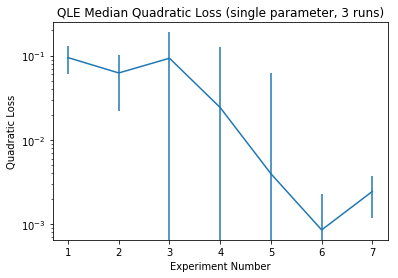

In [12]:
# This cell runs tests on IQLE and QLE and plots the resulting errors and quadratic losses

import matplotlib.pyplot as plt

paulis = ['x', 'y', 'z'] # will be chosen at random. or uncomment below and comment within loop to hard-set

num_exp = 7
num_part = 10
num_tests = 3

qle_list = []
iqle_list = []
true_param_list = []
qle_differences = []
iqle_differences = []
qle_qlosses = []
qle_final_qloss =[]
iqle_qlosses =[]
iqle_final_qloss =[]


do_iqle = True
do_qle = True

plot_time = get_directory_name_by_time(just_date=False) # rather than calling at separate times and causing confusion
title_appendix = str( '(single parameter, ' +str(num_tests)+' runs)')

for i in range(num_tests):
    true_params = [np.random.rand()]
    true_param_list.append(true_params[0])
    true_op=np.random.choice(paulis) # to choose a random True model each time 
    # (Note: not learning between models yet; just learning paramters of true model)

    qle_values = [] # qle True does QLE; False does IQLE
    if do_qle is True:
        qle_values.append(True)
    if do_iqle is True:
        qle_values.append(False)
        
    for qle in qle_values:
        qmd = NewQMDClass(initial_op_list=[true_op], true_operator=true_op, true_param_list=true_params, num_particles=num_part, qle=qle)
        qmd.runAllActiveModelsIQLE(num_exp=num_exp)
        
        mod = qmd.getModelInstance(true_op)
        if qle is True:
            qle_list.append(mod.FinalParams[0][0])
            qle_qlosses.append(mod.QLosses)
            qle_final_qloss.append(mod.QLosses[-1])
        else: 
            iqle_list.append(mod.FinalParams[0][0])
            iqle_qlosses.append(mod.QLosses)
            iqle_final_qloss.append(mod.QLosses[-1])
            
        qmd.killModel(true_op)
        del qmd
    
for i in range(num_tests):
    if do_iqle:
        iqle_diff =np.abs(true_param_list[i]-iqle_list[i])
        iqle_differences.append(iqle_diff)
    if do_qle:
        qle_diff =np.abs(true_param_list[i]-qle_list[i])
        qle_differences.append(qle_diff)

plot_title_appendix = str( str(num_exp)+'_exp_'+str(num_part)+'_particles_'+str(num_tests)+'_runs.png')
#plot_directory = 'test_plots/'+plot_time
plot_directory = 'test_plots/'+plot_time+'/'+plot_title_appendix+'/'


if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)


if do_iqle:
    generate_plots('iqle')

if do_qle:  
    generate_plots('qle')
    


In [11]:

def generate_plots(iqle_qle):
    #qlosses=[]
    if iqle_qle == 'qle':
        qlosses = qle_qlosses
        final_qlosses = qle_final_qloss
        qle_type = 'QLE'
    elif iqle_qle == 'iqle':
        qlosses = iqle_qlosses
        final_qlosses = iqle_final_qloss
        qle_type = 'IQLE'
    else:
        print("Needs to either be QLE or IQLE")
        

            
    ##### Plots #####
    ### Overall results
    
    # Errors histogram
    %matplotlib inline
    plot_description = 'Errors_histogram'
    plt.clf()
    plt.hist(qle_differences, normed=False, bins=30)
    plt.ylabel('Count of '+ qle_type +' runs');
    plt.xlabel('Error');
    plt.title('Count of '+ qle_type +' runs by error margin '+title_appendix);
    plt.savefig(plot_directory+qle_type+'_'+ plot_description)
    plt.plot()    
    
    # Quadratic Loss histogram
    %matplotlib inline
    plot_description='Final_quadratic_loss'
    plt.clf()
    plt.hist(final_qlosses, normed=False, bins=30)
    plt.ylabel('Count of ' +qle_type+' runs');
    plt.xlabel('Error');
    plt.title('Count of ' +qle_type+' runs by final Quadratic Loss '+title_appendix);
    plt.savefig(plot_directory+qle_type+'_'+ plot_description)
    plt.plot()    

    # Quadratic loss development of all tests 
    %matplotlib inline
    plot_description='All_quadratic_loss'
    plt.clf()
    for i in range(num_tests):
        plt.semilogy( range(1,1+len(qle_qlosses[i])), list(qle_qlosses[i]))
    plt.xlabel('Experiment Number');
    plt.ylabel('Quadratic Loss');
    plt.title(qle_type+' Quadratic Loss per experiment '+title_appendix);
    plt.savefig(plot_directory+qle_type+'_'+ plot_description)
    plt.plot()    
    
    
    
            
    ### Averages
    exp_values = {}
    for i in range(num_exp):
        exp_values[i] = []

    for i in range(num_tests): 
        for j in range(len(qlosses[i])):
            exp_values[j].append(qlosses[i][j])

        
        
    medians=[]        
    std_dev=[]
    means=[]
    mins=[]
    maxs = []
    for k in range(num_exp):
        medians.append(np.median(exp_values[k]) )
        means.append(np.mean(exp_values[k]) )
        mins.append(np.min(exp_values[k]) )
        maxs.append(np.max(exp_values[k]) )
        std_dev.append(np.std(exp_values[k]) )

    # Median Quadratic loss
    %matplotlib inline
    plot_description = 'Median'
    plt.clf()
    y = medians
    x = range(1,1+num_exp)
    err = std_dev
    print("Errors are : ", err)
    fig,ax = plt.subplots()
    ax.errorbar(x, y, yerr=err)
    ax.set_yscale('log', nonposy="clip")
    ax.set_xscale('linear')
    plt.xlabel('Experiment Number');
    plt.ylabel('Quadratic Loss');
    plt.title(qle_type + ' Median Quadratic Loss '+title_appendix);
    plt.savefig(plot_directory+qle_type+'_'+ plot_description)
    plt.plot()    


In [ ]:
plot_averages('qle')

In [ ]:
medians

In [ ]:
qle_qlosses

In [ ]:
std_dev

In [ ]:
err

In [ ]:
len(medians)

In [ ]:
len(range(1,1+num_exp))

In [ ]:
err

In [ ]:
%matplotlib inline
plt.clf
# example data
x = np.arange(0.1, 4, 0.5)
y = np.exp(-x)

fig, ax = plt.subplots()
ax.errorbar(x, y, xerr=0.2, yerr=0.4)
plt.show()

In [ ]:
yerror = y/2

In [ ]:
yerror

In [ ]:
%matplotlib inline
plt.clf
# example data
x = np.arange(0.1, 4, 0.5)
y = np.exp(-x)

fig, ax = plt.subplots()
ax.errorbar(x, y, xerr=0.2, yerr=yerror)
plt.show()

In [ ]:

# example data
x = np.arange(0.1, 4, 0.5)
y = np.exp(-x)

# example error bar values that vary with x-position
error = 0.1 + 0.2 * x

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.errorbar(x, y, yerr=error, fmt='-o')
ax0.set_title('variable, symmetric error')

# error bar values w/ different -/+ errors that
# also vary with the x-position
lower_error = 0.4 * error
upper_error = error
asymmetric_error = [lower_error, upper_error]

ax1.errorbar(x, y, xerr=asymmetric_error, fmt='o')
ax1.set_title('variable, asymmetric error')
ax1.set_yscale('log')
plt.show()